<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session6/EVA7_Session6_Normalization_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
# import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import model as m

# EVA 7 Assignment 6

## Goals
1. Write single model.py file that accepts group, batch or layer normalization as parameters.
2. Single notebook must run 3 models - group normalizatiom, layer normalization and Batch normalization + L1 regularization
3. Create graphs with - 

  a. Test & Validation loss for all 3 models together

  b. Test & Validation accuracy for all 3 models together

4. Find 10 misclassified images and show them as 5x2 image matrix in 3 separately annotated images

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device and Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Summary

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = m.Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [6]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, lambda_l1, train_losses, train_acc):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #L1 Regularization
    if lambda_l1 > 0:
        l1 = 0
        for p in model.parameters():
          l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1*l1

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim = True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Define Model Run Function

In [7]:
from torch.optim.lr_scheduler import LambdaLR

def run_model(model, lambda_l1, device, train_loader, test_loader):

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)


    ## Removing LR scheduler for these experiments
    #lambda1 = lambda epoch: 0.65 ** epoch
    #scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

    EPOCHS = 20
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, train_loader, optimizer, lambda_l1, train_losses, train_acc)
        test(model, device, test_loader, test_losses, test_acc)

    return train_acc, train_losses, test_acc, test_losses

## Define function to display wrong predictions and save image

In [8]:

%matplotlib inline
import matplotlib.pyplot as plt


def wrong_predictions(test_loader,model,device, filename):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
    plt.savefig(filename)

## Run Experiments

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.393620729446411 Batch_id=468 Accuracy=76.02: 100%|██████████| 469/469 [00:45<00:00, 10.20it/s]



Test set: Average loss: 0.2468, Accuracy: 9348/10000 (93.48%)

EPOCH: 2


Loss=1.8454561233520508 Batch_id=468 Accuracy=85.25: 100%|██████████| 469/469 [00:46<00:00, 10.19it/s]



Test set: Average loss: 0.6670, Accuracy: 7808/10000 (78.08%)

EPOCH: 3


Loss=1.5893003940582275 Batch_id=468 Accuracy=84.37: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]



Test set: Average loss: 0.3077, Accuracy: 8999/10000 (89.99%)

EPOCH: 4


Loss=1.6199872493743896 Batch_id=468 Accuracy=84.09: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]



Test set: Average loss: 1.0278, Accuracy: 6892/10000 (68.92%)

EPOCH: 5


Loss=1.608737826347351 Batch_id=468 Accuracy=84.10: 100%|██████████| 469/469 [00:46<00:00, 10.08it/s]



Test set: Average loss: 0.3943, Accuracy: 8962/10000 (89.62%)

EPOCH: 6


Loss=1.5574853420257568 Batch_id=468 Accuracy=83.99: 100%|██████████| 469/469 [00:46<00:00, 10.10it/s]



Test set: Average loss: 0.4420, Accuracy: 8625/10000 (86.25%)

EPOCH: 7


Loss=1.6626856327056885 Batch_id=468 Accuracy=83.66: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]



Test set: Average loss: 0.5162, Accuracy: 8411/10000 (84.11%)

EPOCH: 8


Loss=1.618898630142212 Batch_id=468 Accuracy=83.77: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s]



Test set: Average loss: 1.0683, Accuracy: 5987/10000 (59.87%)

EPOCH: 9


Loss=1.5974128246307373 Batch_id=468 Accuracy=83.71: 100%|██████████| 469/469 [00:47<00:00,  9.95it/s]



Test set: Average loss: 0.4820, Accuracy: 8525/10000 (85.25%)

EPOCH: 10


Loss=1.91331148147583 Batch_id=468 Accuracy=83.91: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.4682, Accuracy: 8394/10000 (83.94%)

EPOCH: 11


Loss=1.656359076499939 Batch_id=468 Accuracy=83.93: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s]



Test set: Average loss: 0.3655, Accuracy: 8932/10000 (89.32%)

EPOCH: 12


Loss=1.4884717464447021 Batch_id=468 Accuracy=83.70: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s]



Test set: Average loss: 0.4539, Accuracy: 8845/10000 (88.45%)

EPOCH: 13


Loss=1.5295981168746948 Batch_id=468 Accuracy=83.99: 100%|██████████| 469/469 [00:47<00:00,  9.85it/s]



Test set: Average loss: 0.5287, Accuracy: 8105/10000 (81.05%)

EPOCH: 14


Loss=1.5631957054138184 Batch_id=468 Accuracy=84.03: 100%|██████████| 469/469 [00:47<00:00,  9.90it/s]



Test set: Average loss: 0.6742, Accuracy: 7682/10000 (76.82%)

EPOCH: 15


Loss=1.6547703742980957 Batch_id=468 Accuracy=83.65: 100%|██████████| 469/469 [00:47<00:00,  9.87it/s]



Test set: Average loss: 0.8958, Accuracy: 7069/10000 (70.69%)

EPOCH: 16


Loss=1.435258150100708 Batch_id=468 Accuracy=83.96: 100%|██████████| 469/469 [00:47<00:00,  9.89it/s]



Test set: Average loss: 0.4765, Accuracy: 8489/10000 (84.89%)

EPOCH: 17


Loss=1.8709831237792969 Batch_id=468 Accuracy=83.52: 100%|██████████| 469/469 [00:47<00:00,  9.84it/s]



Test set: Average loss: 0.3685, Accuracy: 8989/10000 (89.89%)

EPOCH: 18


Loss=1.5780107975006104 Batch_id=468 Accuracy=83.66: 100%|██████████| 469/469 [00:47<00:00,  9.96it/s]



Test set: Average loss: 0.5301, Accuracy: 8244/10000 (82.44%)

EPOCH: 19


Loss=1.659160852432251 Batch_id=468 Accuracy=83.63: 100%|██████████| 469/469 [00:46<00:00, 10.01it/s]



Test set: Average loss: 0.6441, Accuracy: 7987/10000 (79.87%)

EPOCH: 20


Loss=1.626248836517334 Batch_id=468 Accuracy=83.75: 100%|██████████| 469/469 [00:46<00:00, 10.03it/s]



Test set: Average loss: 0.3704, Accuracy: 8980/10000 (89.80%)

Total wrong predictions are 1020


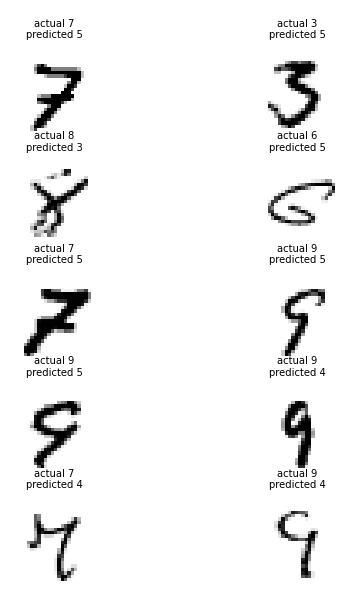

EPOCH: 1


Loss=0.2727527320384979 Batch_id=468 Accuracy=75.73: 100%|██████████| 469/469 [00:45<00:00, 10.33it/s]



Test set: Average loss: 0.1183, Accuracy: 9644/10000 (96.44%)

EPOCH: 2


Loss=0.31825804710388184 Batch_id=468 Accuracy=92.98: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]



Test set: Average loss: 0.0602, Accuracy: 9830/10000 (98.30%)

EPOCH: 3


Loss=0.11899766325950623 Batch_id=468 Accuracy=95.18: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]



Test set: Average loss: 0.0535, Accuracy: 9847/10000 (98.47%)

EPOCH: 4


Loss=0.13257597386837006 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]



Test set: Average loss: 0.0507, Accuracy: 9849/10000 (98.49%)

EPOCH: 5


Loss=0.09323909878730774 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:45<00:00, 10.29it/s]



Test set: Average loss: 0.0402, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.12782210111618042 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0478, Accuracy: 9860/10000 (98.60%)

EPOCH: 7


Loss=0.10986783355474472 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]



Test set: Average loss: 0.0384, Accuracy: 9878/10000 (98.78%)

EPOCH: 8


Loss=0.08494884520769119 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]



Test set: Average loss: 0.0388, Accuracy: 9883/10000 (98.83%)

EPOCH: 9


Loss=0.07972157746553421 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:45<00:00, 10.22it/s]



Test set: Average loss: 0.0330, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.14994721114635468 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]



Test set: Average loss: 0.0359, Accuracy: 9890/10000 (98.90%)

EPOCH: 11


Loss=0.04485952481627464 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0286, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.05239146947860718 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.07702314108610153 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]



Test set: Average loss: 0.0311, Accuracy: 9911/10000 (99.11%)

EPOCH: 14


Loss=0.11004039645195007 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.1530575454235077 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:45<00:00, 10.21it/s]



Test set: Average loss: 0.0283, Accuracy: 9913/10000 (99.13%)

EPOCH: 16


Loss=0.06828152388334274 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:45<00:00, 10.26it/s]



Test set: Average loss: 0.0257, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.07432359457015991 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]



Test set: Average loss: 0.0291, Accuracy: 9903/10000 (99.03%)

EPOCH: 18


Loss=0.030884956941008568 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:45<00:00, 10.23it/s]



Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 19


Loss=0.08562082797288895 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:45<00:00, 10.24it/s]



Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.2547157406806946 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:45<00:00, 10.25it/s]



Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

Total wrong predictions are 76


<Figure size 432x288 with 0 Axes>

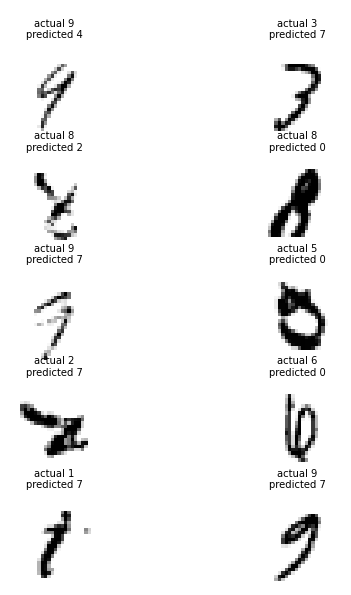

EPOCH: 1


Loss=0.6811726689338684 Batch_id=468 Accuracy=44.50: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]



Test set: Average loss: 0.4317, Accuracy: 8960/10000 (89.60%)

EPOCH: 2


Loss=0.2634373605251312 Batch_id=468 Accuracy=87.51: 100%|██████████| 469/469 [00:45<00:00, 10.21it/s]



Test set: Average loss: 0.1042, Accuracy: 9731/10000 (97.31%)

EPOCH: 3


Loss=0.21185672283172607 Batch_id=468 Accuracy=92.92: 100%|██████████| 469/469 [00:46<00:00, 10.18it/s]



Test set: Average loss: 0.0786, Accuracy: 9770/10000 (97.70%)

EPOCH: 4


Loss=0.3131459653377533 Batch_id=468 Accuracy=94.59: 100%|██████████| 469/469 [00:46<00:00, 10.18it/s]



Test set: Average loss: 0.0652, Accuracy: 9811/10000 (98.11%)

EPOCH: 5


Loss=0.05917758122086525 Batch_id=468 Accuracy=94.91: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0503, Accuracy: 9855/10000 (98.55%)

EPOCH: 6


Loss=0.19146521389484406 Batch_id=468 Accuracy=96.04: 100%|██████████| 469/469 [00:46<00:00, 10.14it/s]



Test set: Average loss: 0.0380, Accuracy: 9890/10000 (98.90%)

EPOCH: 7


Loss=0.05146903172135353 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0402, Accuracy: 9874/10000 (98.74%)

EPOCH: 8


Loss=0.12354975938796997 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:46<00:00, 10.06it/s]



Test set: Average loss: 0.0289, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.1788346767425537 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0322, Accuracy: 9906/10000 (99.06%)

EPOCH: 10


Loss=0.1261671483516693 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0315, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


Loss=0.19737698137760162 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0361, Accuracy: 9886/10000 (98.86%)

EPOCH: 12


Loss=0.15039362013339996 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:46<00:00, 10.05it/s]



Test set: Average loss: 0.0291, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.05879979208111763 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.07733664661645889 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:45<00:00, 10.20it/s]



Test set: Average loss: 0.0314, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.08730029314756393 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:46<00:00, 10.17it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.1032634750008583 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:46<00:00, 10.16it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.07676506787538528 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:46<00:00, 10.15it/s]



Test set: Average loss: 0.0240, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.06198869273066521 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.08352004736661911 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0253, Accuracy: 9932/10000 (99.32%)

EPOCH: 20


Loss=0.08585663884878159 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

Total wrong predictions are 67


<Figure size 432x288 with 0 Axes>

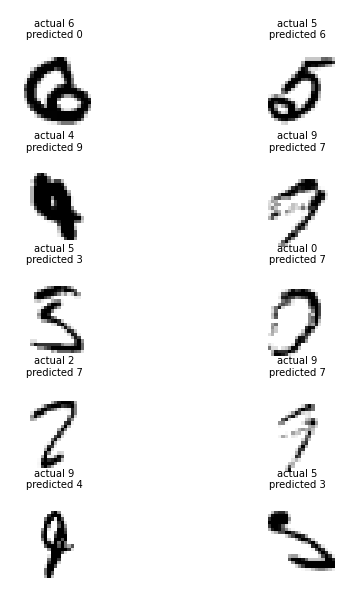

<Figure size 432x288 with 0 Axes>

In [9]:
norm_types = ["Batch", "Layer", "Group"]
l1_weights = [0.01, 0, 0]

train_loss_figs = []
train_acc_figs = []
test_loss_figs = []
test_acc_figs = []

for i, norm_type in enumerate(norm_types):
    
    model =  m.Net(normalization = norm_type).to(device)
    train_accuracy, train_losses, test_accuracy, test_losses = run_model(model, l1_weights[i], device, train_loader, test_loader)

    train_loss_figs.append(train_losses)
    train_acc_figs.append(train_accuracy)
    test_loss_figs.append(test_losses)
    test_acc_figs.append(test_accuracy)

    filename = str(norm_type) + "_" + "l1_value" + "_" + str(l1_weights[i]) + ".png"
    wrong_predictions(test_loader, model, device, filename)






## Draw Plots for Losses & Accuracy

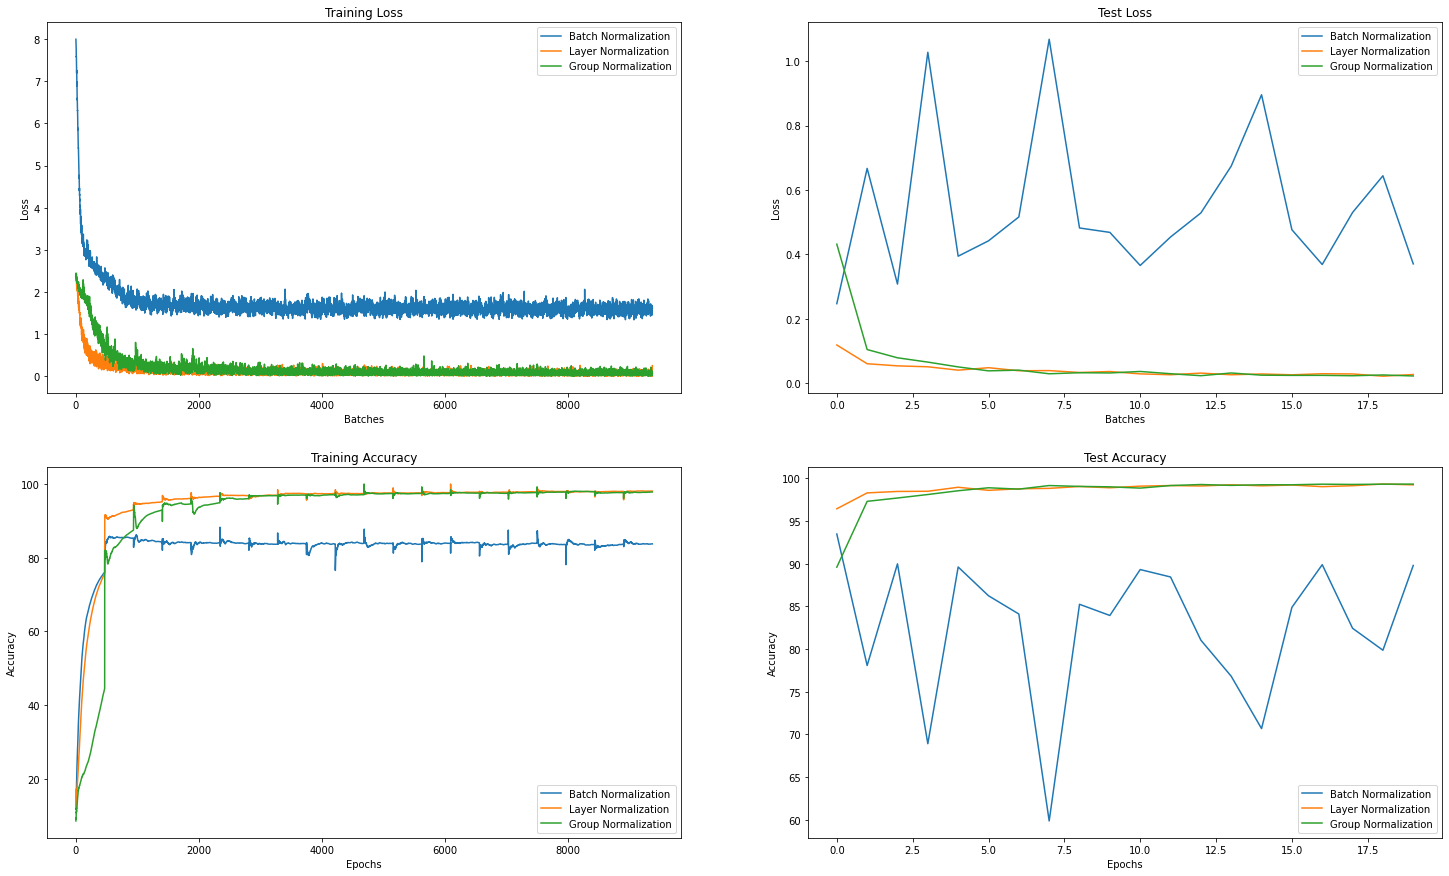

In [10]:
fig, axs = plt.subplots(2,2,figsize=(25,15))
for i, norm_type in enumerate(norm_types):

      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_loss_figs[i], label = norm_type + " Normalization")
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('Batches')
      axs[0,0].set_ylabel('Loss')

      axs[1, 0].plot(train_acc_figs[i], label = norm_type + " Normalization")
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('Epochs')
      axs[1,0].set_ylabel('Accuracy')

      axs[0, 1].plot(test_loss_figs[i], label = norm_type + " Normalization")
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('Batches')
      axs[0,1].set_ylabel('Loss')

      axs[1, 1].plot(test_acc_figs[i], label = norm_type + " Normalization")
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('Epochs')
      axs[1,1].set_ylabel('Accuracy')